# Random Forests: a practical guide

[Alonso Silva](http://www.dim.uchile.cl/~alsilva/) [(@alonsosilva)](https://twitter.com/alonsosilva) | 2019/08/29

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
PATH = "./data"

## An example: the california housing dataset

We are trying to predict the target variable: the median house value for California districts.

In [4]:
df_raw = pd.read_csv(f'{PATH}/Calhousing.csv')

In [5]:
df_raw.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Data processing

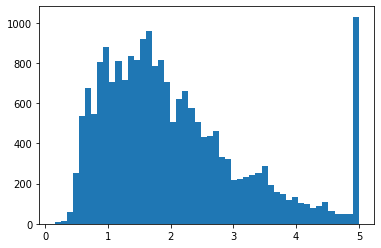

In [6]:
plt.hist(df_raw['Target'], bins=50);

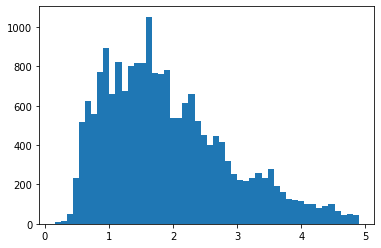

In [7]:
plt.hist(df_raw['Target'][df_raw['Target'] < 4.9], bins=50);

In [8]:
df_raw1 = df_raw[df_raw['Target'] < 4.9].copy()

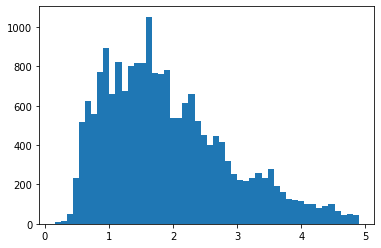

In [9]:
plt.hist(df_raw1['Target'], bins=50);

We are interested on the percentage difference between our predictions and the actuals, not the difference.

In [10]:
df_raw1.Target = np.log(df_raw1.Target)

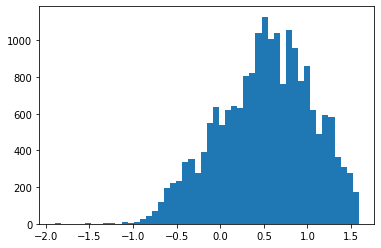

In [11]:
plt.hist(df_raw1['Target'], bins=50);

In [12]:
len(df_raw1)

19608

In [13]:
n_train = 18608

In [14]:
def split_vals(a,n): return a[:n], a[n:]

In [15]:
df_raw1 = df_raw1.sample(frac=1).reset_index(drop=True) # Shuffle the rows
X_trn, X_val = split_vals(df_raw1.drop(['Target'], axis=1), n_train)
y_trn, y_val = split_vals(df_raw1['Target'], n_train)

In [16]:
y_val.reset_index(drop=True);

In [17]:
len(X_trn)==len(y_trn), len(X_val)==len(y_val)

(True, True)

In [18]:
len(y_trn), len(y_val)

(18608, 1000)

In [19]:
cols = df_raw1.columns; cols

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'Target'],
      dtype='object')

Scaling the features.

In [20]:
X_trn_s = (X_trn - X_trn.mean())/X_trn.std()
X_val_s = (X_val - X_trn.mean())/X_trn.std()

## Data analysis

In [21]:
import math

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

To plot predictions vs actuals

In [22]:
def scatter_predictions(y_pred, y_true):
    plt.figure(figsize=(6, 6))
    plt.xlabel('prediction')
    plt.ylabel('true target')
    plt.xlim(-1, 6)
    plt.ylim(-1, 6)
    plt.scatter(np.exp(y_pred), np.exp(y_true))
    plt.show()

For linear regression, we need to use the scaled columns.

In [23]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_trn_s, y_trn)
print('train error: %0.3f, valid error: %0.3f' % (rmse(lm.predict(X_trn_s), y_trn),rmse(lm.predict(X_val_s), y_val)))
print('train score: %0.3f, valid score: %0.3f' % (lm.score(X_trn_s, y_trn),lm.score(X_val_s, y_val)))

train error: 0.334, valid error: 0.337
train score: 0.603, valid score: 0.614


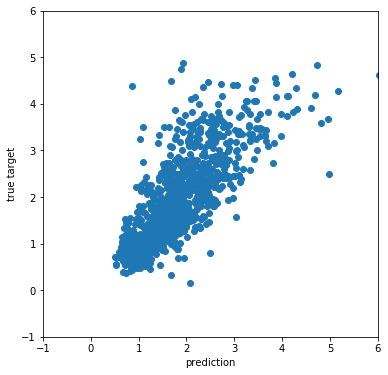

In [24]:
scatter_predictions(lm.predict(X_val_s), y_val)

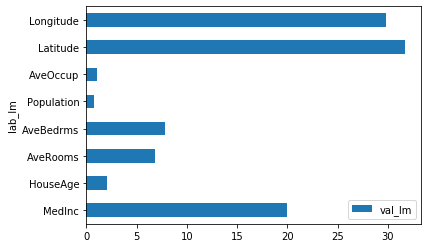

In [25]:
# Feature importance
featcoef_lm = lm.coef_
rel_featcoef_lm = 100*np.abs(featcoef_lm)/np.sum(np.abs(featcoef_lm))
lab = df_raw.drop(['Target'], axis=1).columns
df_featcoef_lm = pd.DataFrame({'lab_lm': lab, 'val_lm': rel_featcoef_lm})
df_featcoef_lm.plot.barh(x='lab_lm', y='val_lm');

## Random forests

In [26]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

rfm = RandomForestRegressor(n_estimators=50, min_samples_leaf=1, max_features=.5, n_jobs=-1, oob_score=True)
rfm.fit(X_trn, y_trn)
print('train error: %0.3f, valid error: %0.3f' % (rmse(rfm.predict(X_trn), y_trn),rmse(rfm.predict(X_val), y_val)))
print('train score: %0.3f, valid score: %0.3f' % (rfm.score(X_trn, y_trn),rfm.score(X_val, y_val)))

train error: 0.084, valid error: 0.234
train score: 0.975, valid score: 0.814


Holy cow! Our error diminished by $30\%$ and our score improved by $33\%$.

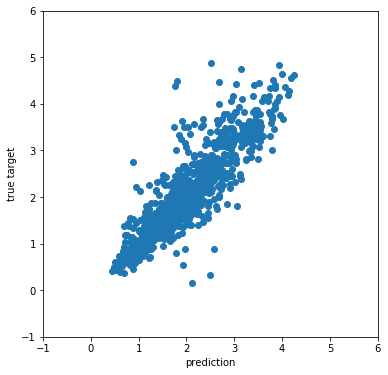

In [27]:
scatter_predictions(rfm.predict(X_val), y_val)

Our predictions are much less disperse compared to the predictions of the linear model.

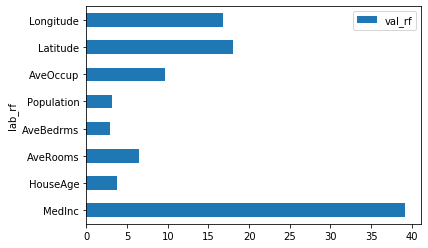

In [28]:
featcoef_rfm = rfm.feature_importances_
rel_featcoef_rfm = 100*np.abs(featcoef_rfm)/np.sum(np.abs(featcoef_rfm))
df_featcoef_rfm = pd.DataFrame({'lab_rf': lab, 'val_rf': rel_featcoef_rfm})
df_featcoef_rfm.plot.barh(x='lab_rf', y='val_rf');

The most important feature of the price of a house is the median income in the bloc. Location features (Longitude and Latitude) seem to be very important as well (but less important compared to the feature importance given by the linear model).

## Bonus track: Prediction intervals of random forests

Random forests give us the estimation given by several decision trees, so we get for free the standard deviation of these predictions.

In [29]:
preds = np.stack([t.predict(X_val) for t in rfm.estimators_])
print('Predicted value first house: %0.3f, Standard deviation of the prediction: %0.3f' % 
      (np.mean(preds[:,0]), np.std(preds[:,0])))

Predicted value first house: 0.572, Standard deviation of the prediction: 0.131


We compute the predictions and their standard deviations.

In [30]:
pred = [np.mean(preds[:,i]) for i in range(len(X_val))]
pred_std = [np.std(preds[:,i]) for i in range(len(X_val))]

In [31]:
y_val = y_val.reset_index(drop=True)

How many predictions are within 1 standard deviation? 2 standard deviations? 3 standard deviations

In [32]:
lower1 = [pred[i]-1*pred_std[i] for i in range(len(pred))]
upper1 = [pred[i]+1*pred_std[i] for i in range(len(pred))]
print('Within 1 standard deviation: %0.1f%%' %
(100*(sum([lower1[i] <= y_val.iloc[i] <= upper1[i] for i in range(len(y_val))])/len(y_val))))

Within 1 standard deviation: 80.1%


In [33]:
lower2 = [pred[i]-2*pred_std[i] for i in range(len(pred))]
upper2 = [pred[i]+2*pred_std[i] for i in range(len(pred))]
print('Within 2 standard deviations: %0.1f%%' %
(100*sum([lower2[i] <= y_val.iloc[i] <= upper2[i] for i in range(len(y_val))])/len(y_val)))

Within 2 standard deviations: 97.5%


In [34]:
lower3 = [pred[i]-3*pred_std[i] for i in range(len(pred))]
upper3 = [pred[i]+3*pred_std[i] for i in range(len(pred))]
print('Within 3 standard deviations: %0.1f%%' %
(100*sum([lower3[i] <= y_val.iloc[i] <= upper3[i] for i in range(len(y_val))])/len(y_val)))

Within 3 standard deviations: 99.6%


Compared to the [68-95-99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) of the normal distribution, I think it's quite a remarkable empirical result. 

Sources:
+ [Gradient Boosting: a practical guide](https://nbviewer.jupyter.org/github/ogrisel/notebooks/blob/master/sklearn_demos/Gradient%20Boosting.ipynb)
+ [FastAI Machine Learning for Coders](https://course18.fast.ai/ml)